# marsupial: finding and identifying animals in camera trap images

## Example uses

There are many ways to use our models to make predictions and detections. 
Our models are by default available as `PyTorch` weights, which makes them easy to integrate into any workflows using `PyTorch` or the broader `Torch` ecosystem.
The model weights can also be easil converted into other popular deep learning formats, including light weight options like onnx and open vino. 

This guide is aimed at users who have some knowleged of Python; if you aren't familiar with using Python for deep learning it would be a good idea to have a look at the excellent tutorials available from `PyTorch`.

### Making predictions with marsupial using PyTorch

PyTorch is one of the leading industry standard libraries for machine learning and deep learning. 

First, we need to import a few libraries.

In [1]:
import os
import re
import json
import pathlib
import subprocess
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path 
from PIL import Image
from datetime import datetime

%matplotlib inline  
import torchvision
import matplotlib.pyplot as plt

/media/dwheeler/spinner/Linux_space/miniconda3/envs/marsupial/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Then, we can load in one of our models. In this case, we will use a  72 species model.

In [2]:
# For this example, we will load in the 72 species model
model = torch.hub.load('ultralytics/yolov5', 'custom', 'weights/marsupial_72s.pt')

Using cache found in /home/dwheeler/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-1-31 Python-3.9.15 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce GTX 970, 4040MiB)

Fusing layers... 
Model summary: 213 layers, 7204309 parameters, 0 gradients
Adding AutoShape... 


Once the model is loaded, we can pass objects to it and save them in memory as predictions. 

In [3]:
# Specify the path to an image file to predict on
image = "data/BrushtailPossum.jpg"

# Pass the image path to our model
results = model(image)

# If we print the result, we can see what we get and how long it took to process
print(results)

# OR we can print this as a nice dataframe:
results.pandas()
results.xyxy[0]  # im predictions (tensor)
results.pandas().xyxy[0]  # im predictions (pandas)

image 1/1: 395x526 1 Mountain Brushtail Possum
Speed: 17.1ms pre-process, 13.2ms inference, 1.7ms NMS per image at shape (1, 3, 480, 640)


,xmin,ymin,xmax,ymax,confidence,class,name
0,145.162552,193.935318,311.823822,288.557678,0.935862,20,Mountain Brushtail Possum


Our model has found one possum in the image; let's visualise the model's predictions to see if they look reasoable:

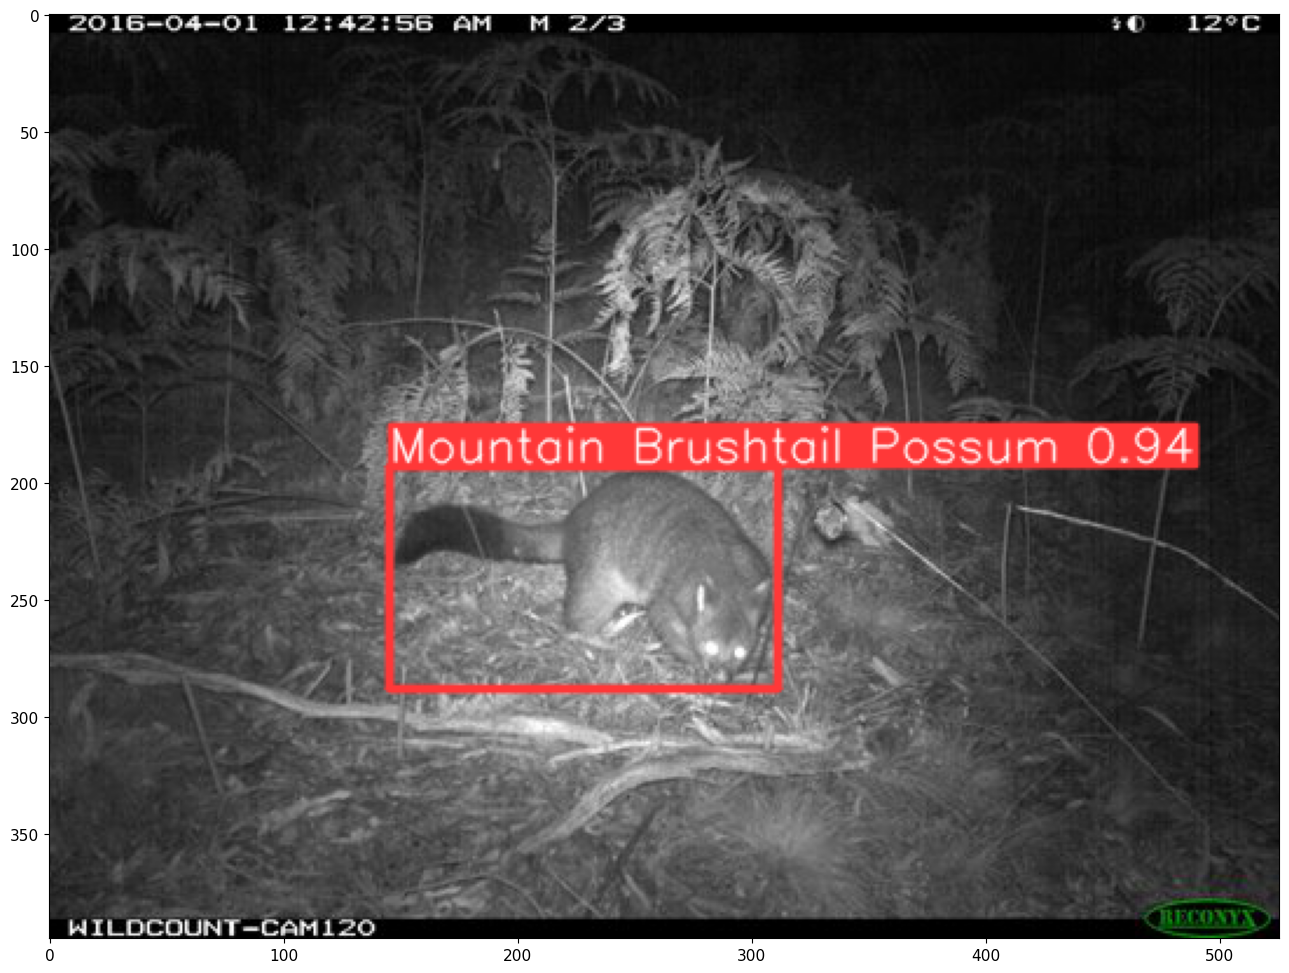

In [7]:
%matplotlib inline  

fig, ax = plt.subplots(figsize=(16, 12))
ax.imshow(results.render()[0])
plt.show()

That looks pretty good! The model has drawn a bounding box perfectly covering the one animal in this image, which looks to pretty clearly be a possum walking along the ground.

#### Building functions with marsupial's models

Now that we can make a prediction on one single image, we can then build some functions to allow us to make predictions on multiple images.
We can also make functions to help us visualise and summarise results.

In [1]:
"""
Prediction functions
"""

def predict_single_image(image_file):
    
    im = image_file
    results = model(im)
    results.pandas().xyxy[0] 
    
    return(results.pandas().xyxy[0])

def predict_images(image_dir, summary = False):
    
    predictions = [] 
    
    image_dir = pathlib.Path(image_dir)
    
    for image in tqdm(image_dir.glob("*.jpg")):
        
        prediction = predict_single_image(image)
        prediction['fullpath'] = image
        prediction['filename'] = os.path.basename(image) 
        predictions.append(prediction)
                       
    prediction_df = pd.concat(predictions)
    
    if summary == True:
        print("Detection Summary")
        print(prediction_df.groupby(['name'])['name'].count().sort_values(ascending=False))
        
    return(prediction_df)

"""
Image EXIF utilities

This set of functions is to extract information from image EXIF data. 

These functions are very useful when working with EXIF anotated images, like the NSWNP Wildcount dataset.
"""

def species_annotation_from_exif(image_file):
    # Get original species ID
    cmd="exiftool -Keywords " + '''"''' + str(image_file) + '''"'''
    image_keywords = subprocess.getoutput([cmd])
    species = re.findall(r'(?<=a\)\s).+?(?=\s\([a-zA-z])', image_keywords)
    return(species)

def date_time_original_from_exif(image_file):
    # Get DateTimeOriginal
    cmd="exiftool -DateTimeOriginal " + '''"''' + str(image_file) + '''"'''
    date_time_original = subprocess.getoutput([cmd])
    date_time_original = re.findall(r'(?<=:\s)(.*)', date_time_original)
    return(date_time_original)

def camera_name_from_exif(image_file):
    # Get Camera Name
    cmd="exiftool -UserLabel " + '''"''' + str(image_file) + '''"'''
    camera_name = subprocess.getoutput([cmd])
    camera_name = re.findall(r'(?<=:\s)(.*)', camera_name)
    return(camera_name)

def date_from_exif(image_file):
    # Get date
    cmd = "exiftool -DateTimeOriginal " + '''"''' + str(image_file) + '''"'''
    date = subprocess.getoutput([cmd])
    date = re.findall(r'(?<=:\s)([^\s]+)', date)
    return(date)

def time_from_exif(image_file):
    # Get time
    cmd = "exiftool -DateTimeOriginal " + '''"''' + str(image_file) + '''"'''
    time = subprocess.getoutput([cmd])
    time = time[time.rindex(' ')+1:]
    return(time)

We can then pass a path to a directory containing images, and this function will recursively look for any images, load them in, and make predictions on all of the images using our model.

Predictions will then be saved into a `pandas` dataframe, which can be analysed in Python or easily exported into a spreadsheet for analysis using other tools like R or Excel,

In [36]:
predictions = predict_images("data") 
 
predictions

12it [00:02,  4.40it/s]


,xmin,ymin,xmax,ymax,confidence,class,name,fullpath,filename
0,146.202438,193.257645,311.983063,288.033905,0.933581,20,Mountain Brushtail Possum,data/BrushtailPossum.jpg,BrushtailPossum.jpg
0,455.115234,490.108337,961.205994,828.426147,0.903416,64,Koala,data/koala2.jpg,koala2.jpg
0,989.692383,546.069824,1325.369019,1051.991821,0.881009,23,Cat,data/cat1.jpg,cat1.jpg
0,38.509991,161.055267,290.907806,300.832245,0.936678,56,Wedge-tailed Eagle,data/Eagle.jpg,Eagle.jpg
0,728.963318,884.916992,1413.578491,1293.600586,0.682730,23,Cat,data/tawny_frogmouth.jpg,tawny_frogmouth.jpg
0,602.422974,716.410583,986.186890,1018.210938,0.933168,29,Australian Magpie,data/magpie.jpg,magpie.jpg
0,0.777562,292.635437,422.179230,626.650146,0.933250,23,Cat,data/cat.jpg,cat.jpg
0,619.546326,715.897156,1578.911865,1513.666138,0.934307,6,Red Fox,data/red_fox.jpg,red_fox.jpg
0,140.057373,23.666748,998.016418,1030.468994,0.901568,2,Eastern Grey Kangaroo,data/easter_grey_kangaroo.jpg,easter_grey_kangaroo.jpg
0,1087.885010,814.615295,1848.107056,1122.206299,0.901736,1,Common Brushtail Possum,data/brushtail_possum.jpg,brushtail_possum.jpg


We can also print out a summary of the number of observations for each species detected:

In [54]:
# We can enable printing a summary by setting summary to True
predictions = predict_images("data", summary = True) 

# OR we can always just do it ourselves with the output of predict_images:
# print(predictions.groupby(['name'])['name'].count().sort_values(ascending=False))

12it [00:04,  2.73it/s]

Detection Summary


name
Cat                          3
Australian Magpie            1
Common Brushtail Possum      1
Eastern Grey Kangaroo        1
Koala                        1
Mountain Brushtail Possum    1
Red Fox                      1
Wedge-tailed Eagle           1
Name: name, dtype: int64


### Gradio web applications

Here's an example of simple web application that can use one of our models to make predictions on input images:

In [8]:
# Marsupial Demo
import gradio as gr
import torch
import torchvision
import numpy as np
from PIL import Image

# Load Marsupial model
# TODO: Allow user selectable model?

model = torch.hub.load('ultralytics/yolov5:v6.2', 'custom', "weights/marsupial_72s_lures.pt", trust_repo=True)

def yolo(im, size=640):
    g = (size / max(im.size))  # gain
    im = im.resize((int(x * g) for x in im.size))  # resize
    
    #model = torch.hub.load('ultralytics/yolov5', 'custom', "weights/marsupial_72s_lures.pt")
    
    results = model(im)  # inference
    results.render()  # updates results.imgs with boxes and labels
    result = Image.fromarray(results.imgs[0])
    return result

inputs = gr.Image(type="pil", label="Input Image")
outputs = gr.Image(type="pil", label="Output Image")

title = "Marsupial"
description = "Detect and identify 72 different species of Australian wildlife using Marsupial's most detailed model"
article = "<p style='text-align: center'>This app makes predictions using a YOLOv5s model that was trained to detect and identify 72 different species of animals found in Australia in camera trap images; find out more about the project on <a href='https://github.com/Sydney-Informatics-Hub/marsupial'>GitHub</a>. This app was built by Dr Henry Lydecker and Dr Gordon MacDonald at the Sydney Informatics Hub, a Core Research Facility at the University of Sydney. Find out more about the YOLO model from the original creator, <a href='https://pjreddie.com/darknet/yolo/'>Joseph Redmon</a>. YOLOv5 is a family of compound-scaled object detection models trained on the COCO dataset and developed by Ultralytics, and includes simple functionality for Test Time Augmentation (TTA), model ensembling, hyperparameter evolution, and export to ONNX, CoreML and TFLite. <a href='https://github.com/ultralytics/yolov5'>Source code</a> | <a href='https://pytorch.org/hub/ultralytics_yolov5'>PyTorch Hub</a></p>"

examples = [['data/eastern_grey_kangaroo.jpg'],['data/red_fox.jpg'], ['data/koala2.jpg'],['data/cat1.jpg']]

gr.Interface(yolo, inputs, outputs, title=title, description=description, article=article, examples=examples, theme="default").launch(enable_queue=True)

Using cache found in /home/dwheeler/.cache/torch/hub/ultralytics_yolov5_v6.2
YOLOv5 🚀 2023-1-31 Python-3.9.15 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce GTX 970, 4040MiB)

Fusing layers... 
Model summary: 213 layers, 7207006 parameters, 0 gradients
Adding AutoShape... 


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "/media/dwheeler/spinner/Linux_space/miniconda3/envs/marsupial/lib/python3.9/site-packages/gradio/routes.py", line 344, in run_predict
    output = await app.get_blocks().process_api(
  File "/media/dwheeler/spinner/Linux_space/miniconda3/envs/marsupial/lib/python3.9/site-packages/gradio/blocks.py", line 1012, in process_api
    result = await self.call_function(
  File "/media/dwheeler/spinner/Linux_space/miniconda3/envs/marsupial/lib/python3.9/site-packages/gradio/blocks.py", line 830, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/media/dwheeler/spinner/Linux_space/miniconda3/envs/marsupial/lib/python3.9/site-packages/anyio/to_thread.py", line 31, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/media/dwheeler/spinner/Linux_space/miniconda3/envs/marsupial/lib/python3.9/site-packages/anyio/_backends/_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "/